# Extract Sentences to Parse

In [1]:
def extract_sentences_from_gold_standard(file_path):
    original_sentences = []
    gold_trees = []
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        i = 0
        while i < len(lines):
            line = lines[i].strip()
            if line and line.split(':', 1)[0].strip().replace('a', '').replace('b', '').isdigit():
                sentence = line.split(':', 1)[1].strip()
                original_sentences.append(sentence.lower())
                # The gold tree notation is on the third line after the sentence line
                gold_tree = lines[i+2].strip()
                gold_trees.append(gold_tree)
                i += 3  # Move to the next block of sentence
            else:
                i += 1  # Move to the next line
    return original_sentences, gold_trees

# Specify the path to your gold standard file
file_path = 'L95_10sentencesTaggedAndParsed_goldStandard_corrected.txt'

# Extract the sentences and gold trees
extracted_sentences, gold_trees = extract_sentences_from_gold_standard(file_path)
print(extracted_sentences)
print(gold_trees)


["my aunt's can opener can open a drum.", 'the old car broke down in the car park.', 'at least two men broke in and stole my tv.', 'kim and sandy both broke up with their partners.', 'the horse as well as the rabbits which we wanted to eat has escaped.', "it was my aunt's car which we sold at auction last year in february.", 'natural disasters – storms, flooding, hurricanes – occur infrequently but cause devastation that strains resources to breaking point.', 'letters delivered on time by old-fashioned means are increasingly rare, so it is as well that that is not the only option available.', "english also has many words of more or less unique function, including interjections (oh, ah), negatives (no, not), politeness markers (please, thank you), and the existential 'there' (there are horses but not unicorns) among others.", 'the penn treebank tagset was culled from the original 87-tag tagset for the brown corpus.', 'for example the original brown and c5 tagsets include a separate tag 

#  Charniak-Johnson parser or Brown Reranking Parser
https://aclanthology.org/P05-1022.pdf

In [2]:
from bllipparser import RerankingParser
rrp = RerankingParser.fetch_and_load('WSJ+Gigaword-v2', verbose=False)



In [3]:
rrp.simple_parse("It's that easy.")
# as a tagger:
# rrp.tag("Time flies while you're having fun.")

charniak_trees = [rrp.simple_parse(sentence) for sentence in extracted_sentences]

# Berkeley Neural Parser

In [4]:
import benepar, spacy

benepar.download('benepar_en3')
nlp = spacy.load('en_core_web_md')
if spacy.__version__.startswith('2'):
        nlp.add_pipe(benepar.BeneparComponent("benepar_en3"))
else:
    nlp.add_pipe("benepar", config={"model": "benepar_en3"})

[nltk_data] Error loading benepar_en3: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
/home/tihorstm/L95/Project_Code/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [5]:
berkeley_trees = []
for sentence in extracted_sentences:
    doc = nlp(sentence)
    sent = list(doc.sents)[0]
    parse_tree = sent._.parse_string
    berkeley_trees.append(parse_tree)

# print(berkeley_trees)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


/home/tihorstm/L95/Project_Code/.venv/lib/python3.8/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


# Visualize trees

In [6]:
from nltk.tree import *
from IPython.display import display, Image, SVG
from cairosvg import svg2png

def printTree(parsed_tree: str, parser_name: str, index: int, saveFile = True):
    nltk_tree = Tree.fromstring(parsed_tree) # convert into NLTK tree

    # nltk_tree.pformat_latex_qtree() # get latex code representation of the tree compatible with the LaTeX qtree package

    # print to console
    # tree.pretty_print(unicodelines=True, nodedist=4) # print to console

    # print as SVG
    svg_format = nltk_tree._repr_svg_()
    # display(SVG(svg_format))

    if saveFile:
        with open(f"ParseTrees/{parser_name}_{index}.svg", 'w') as f:  # open a file in write mode
            f.write(svg_format)  # write the SVG content to the file
        svg2png(bytestring=svg_format,write_to=f"ParseTrees/{parser_name}_{index}.png")
    
    return nltk_tree

def tree_to_forest(tree):
    """
    Convert an NLTK Tree object's string representation into a LaTeX forest package representation.
    Escapes special LaTeX characters.
    """
    # Base case: if the tree is a leaf, just return the escaped leaf
    if isinstance(tree, str):
        return f"[{tree}]"
    
    # Recursively convert each subtree
    escaped_label = tree.label()
    result = '[' + ' '.join([escaped_label] + [tree_to_forest(t) for t in tree]) + ']'
    return result

def toLatexFigures(latex_trees, parser_names, indices):
    with open("parse_trees.tex", 'w') as f:
        for latex_tree, parser_name, index in zip(latex_trees, parser_names, indices):
            f.write('\\thispagestyle{empty}\n')
            f.write('\\begin{center}\n')
            f.write(f'{{\\Large \\textbf{{Model: {parser_name} - Sentence {index+1}}}}}\n\n')  # Header
            f.write('\\vspace*{\\fill}\n')  # Center the tree vertically
            f.write('\\begin{forest}\n')
            f.write(latex_tree + '\n')
            f.write('\\end{forest}\n')
            f.write('\\vspace*{\\fill}\n')  # Center the tree vertically
            f.write('\\end{center}\n')
            f.write('\\newpage\n\n')  # Ensures a new page for the next tree

latex_trees = []
parser_names = []
indices = []

for index, (charniak_tree, berkeley_tree, gold_tree) in enumerate(zip(charniak_trees, berkeley_trees, gold_trees)):
    charniak_tree_nltk = printTree(charniak_tree, "Charniak", index, True)
    berkeley_tree_nltk = printTree(berkeley_tree, "Berkeley", index, True)
    gold_tree_nltk = printTree(gold_tree, "Gold", index, True)

    # Convert the NLTK tree objects to forest package strings
    charniak_forest = tree_to_forest(charniak_tree_nltk)
    berkeley_forest = tree_to_forest(berkeley_tree_nltk)
    gold_forest = tree_to_forest(gold_tree_nltk)

    # Append the LaTeX forest representations to the list
    latex_trees.append(charniak_forest)
    latex_trees.append(berkeley_forest)
    latex_trees.append(gold_forest)

    parser_names.extend(["Charniak", "Berkeley", "Gold"])
    indices.extend([index, index, index])

toLatexFigures(latex_trees, parser_names, indices)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

# Quantitative Evaluation Using EVALB

Adjust output to unify all three results

In [7]:
from datetime import datetime
import re

def adjust_gold_trees(trees):
    adjusted_trees = []
    for index, tree in enumerate(trees):

        # Remove all ":<number>" occurrences
        tree = re.sub(r':\d+', '', tree)

        # Replace specific word forms
        replacements = {
            "break+ed": "broke",
            "man+s": "men",
            "Kim": "kim",
            "rabbit+s": "rabbits",
            "be+ed": "was",
            "disaster+s": "disasters",
            "letter+s": "letters",
            "steal+ed": "stole",
            "Sandy": "sandy",
            "want+ed": "wanted",
            "sell+ed": "sold",
            "storm+s": "storms",
            "deliver+ed": "delivered",
            "have+s": "has",
            "Penn": "penn",
            "Brown": "brown",
            "partner+s":"partners",
            "escape+ed":"escaped",
            "February":"february",
            "flood+ing":"flooding",
            "fashion+ed":"fashioned",
            "word+s":"words",
            "Treebank":"treebank",
            "tagset+s":"tagsets",
            "hurricane+s":"hurricanes",
            "be+s":"is",
            "be+":"are",
            "include+ing":"including",
            "cull+ed":"culled",
            "form+s":"forms",
            "strain+s":"strains",
            "interjection+s":"interjections",
            "verb+s":"verbs",
            "resource+s":"resources",
            "not+":"not",
            "negative+s":"negatives",
            "Vdd":"vdd",
            "break+ing":"breaking",
            "marker+s":"markers",
            "do+ed":"did",
            "horse+s":"horses",
            "Vdg":"vdg",
            "unicorn+s":"unicorns",
            "other+s":"others"
        }

        for old, new in replacements.items():
            tree = tree.replace(old, new)

        # Transform cases
        tree = tree.replace("'s+", "'s")
        tree = tree.replace("\\(", "-LRB-")
        tree = tree.replace("\\)", "-RRB-")

        # print new trees
        # print new gold trees to files
        printTree(tree, "Gold", index, True)

        # Remove the first "(TOP " and the last ")"
        # tree = tree[5:-1].strip() # is ignoed anyway in evalb

        adjusted_trees.append(tree)
    return adjusted_trees

adjusted_gold_trees = adjust_gold_trees(gold_trees)





adjusted_charniak_trees = [tree[4:-1].strip() for tree in charniak_trees] # strip S1

# write to file
def write_to_file(list_of_trees, file_path):
    with open(file_path, 'w', encoding='utf-8') as file:
        for tree in list_of_trees:
            file.write(tree + '\n')

# Write adjusted trees to files
write_to_file(adjusted_charniak_trees, f"charniak_trees_{datetime.today().strftime('%Y-%m-%d')}.txt")
write_to_file(berkeley_trees, f"berkeley_trees_{datetime.today().strftime('%Y-%m-%d')}.txt")
write_to_file(adjusted_gold_trees, f"gold_trees_{datetime.today().strftime('%Y-%m-%d')}.txt")



## Run Evalb (https://nlp.cs.nyu.edu/evalb/)

In [39]:
import subprocess
import pandas as pd

def run_evalb(evalb_path, gold_file, test_file, result_file):

    # Command to run EVALB
    command = [evalb_path, '-p', 'EVALB/COLLINS.prm', gold_file, test_file]

    # Run EVALB and write output to result_file
    with open(result_file, 'w') as output_file:
        subprocess.run(command, stdout=output_file, text=True)


for parser_to_eval in ["berkeley"]:
    test_file = f"{parser_to_eval}_trees.txt"
    evalb_path = 'EVALB/evalb'  
    result_file_path = f'{test_file.split("_")[0]}_evalb_{datetime.today().strftime("%Y-%m-%d")}.txt'

    # Running EVALB
    run_evalb(evalb_path, "gold_trees.txt", test_file, result_file_path)

    def read_evalb_results_to_dataframe(result_file_path):
        # Initialize lists to hold data
        data = {
            'Sent. ID': [],
            'Sent. Len.': [],
            'Stat.': [],
            'Recall': [],
            'Precision': [],
            'Matched Bracket': [],
            'Bracket Gold': [],
            'Bracket Test': [],
            'Cross Bracket': [],
            'Correct Words': [],
            'Correct Tags': [],
            'Tag Accuracy': []
        }

        # Read the file and parse the results
        with open(result_file_path, 'r') as file:
            data_block_reached = False
            for line in file:
                if line.startswith("="):  # Found a data line start
                    if not data_block_reached:
                        data_block_reached = True
                        continue
                    else:
                        break
                if data_block_reached:
                    # Split the line into components based on whitespace
                    parts = line.split()
                    print(parts)
                    # Populate the data lists
                    data['Sent. ID'].append(int(parts[0]))
                    data['Sent. Len.'].append(int(parts[1]))
                    data['Stat.'].append(int(parts[2]))
                    data['Recall'].append(float(parts[3]))
                    data['Precision'].append(float(parts[4]))
                    data['Matched Bracket'].append(int(parts[5]))
                    data['Bracket Gold'].append(int(parts[6]))
                    data['Bracket Test'].append(int(parts[7]))
                    data['Cross Bracket'].append(int(parts[8]))
                    data['Correct Words'].append(int(parts[9]))
                    data['Correct Tags'].append(int(parts[10]))
                    data['Tag Accuracy'].append(float(parts[11]))

        # Create a DataFrame from the lists
        df = pd.DataFrame(data)
        return df

    # Optionally, read and print the results
    with open(result_file_path, 'r') as file:
        results = file.read()
        print(results)

    df_results = read_evalb_results_to_dataframe(result_file_path)

df_results

  Sent.                        Matched  Bracket   Cross        Correct Tag
 ID  Len.  Stat. Recal  Prec.  Bracket gold test Bracket Words  Tags Accracy
   1   10    0   62.50  83.33     5      8    6      1      9     9   100.00
   2   10    0   55.56  83.33     5      9    6      0      9     9   100.00
   3   11    0   60.00  66.67     6     10    9      1     10     9    90.00
   4   10    0   45.45  83.33     5     11    6      0      9     7    77.78
   5   15    0   66.67  62.50    10     15   16      0     14    13    92.86
   6   16    0   63.16  75.00    12     19   16      1     15    13    86.67
   7   21    0   50.00  76.47    13     26   17      0     18    17    94.44
   8   27    0   61.76  87.50    21     34   24      0     24    23    95.83
   9   53    0   35.71  60.61    20     56   33      6     43    38    88.37
  10   18    0   38.89  70.00     7     18   10      2     16    12    75.00
  11   40    0   25.00  28.12     9     36   32     15     38    32    84.21
 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,Sent. ID,Sent. Len.,Stat.,Recall,Precision,Matched Bracket,Bracket Gold,Bracket Test,Cross Bracket,Correct Words,Correct Tags,Tag Accuracy
0,1,10,0,62.50,83.33,5,8,6,1,9,9,100.00
1,2,10,0,55.56,83.33,5,9,6,0,9,9,100.00
2,3,11,0,60.00,66.67,6,10,9,1,10,9,90.00
3,4,10,0,45.45,83.33,5,11,6,0,9,7,77.78
4,5,15,0,66.67,62.50,10,15,16,0,14,13,92.86
5,6,16,0,63.16,75.00,12,19,16,1,15,13,86.67
6,7,21,0,50.00,76.47,13,26,17,0,18,17,94.44
7,8,27,0,61.76,87.50,21,34,24,0,24,23,95.83
8,9,53,0,35.71,60.61,20,56,33,6,43,38,88.37
9,10,18,0,38.89,70.00,7,18,10,2,16,12,75.00


# Create Confusion Matrix of POS Tags

[('my', 'PRP$'), ('aunt', 'NN'), ("'s", 'POS'), ('can', 'NN'), ('opener', 'NN'), ('can', 'MD'), ('open', 'VB'), ('a', 'DT'), ('drum', 'NN'), ('.', '.'), ('the', 'DT'), ('old', 'JJ'), ('car', 'NN'), ('broke', 'VBD'), ('down', 'RP'), ('in', 'IN'), ('the', 'DT'), ('car', 'NN'), ('park', 'NN'), ('.', '.'), ('at', 'RB'), ('least', 'RBS'), ('two', 'CD'), ('men', 'NNS'), ('broke', 'VBD'), ('in', 'RP'), ('and', 'CC'), ('stole', 'VBD'), ('my', 'PRP$'), ('tv', 'NN'), ('.', '.'), ('kim', 'NNP'), ('and', 'CC'), ('sandy', 'NNP'), ('both', 'RB'), ('broke', 'VBD'), ('up', 'RP'), ('with', 'IN'), ('their', 'PRP$'), ('partners', 'NNS'), ('.', '.'), ('the', 'DT'), ('horse', 'NN'), ('as', 'RB'), ('well', 'RB'), ('as', 'RB'), ('the', 'DT'), ('rabbits', 'NNS'), ('which', 'WDT'), ('we', 'PRP'), ('wanted', 'VBD'), ('to', 'TO'), ('eat', 'VB'), ('has', 'VBZ'), ('escaped', 'VBN'), ('.', '.'), ('it', 'PRP'), ('was', 'VBD'), ('my', 'PRP$'), ('aunt', 'NN'), ("'s", 'POS'), ('car', 'NN'), ('which', 'WDT'), ('we', 'PR

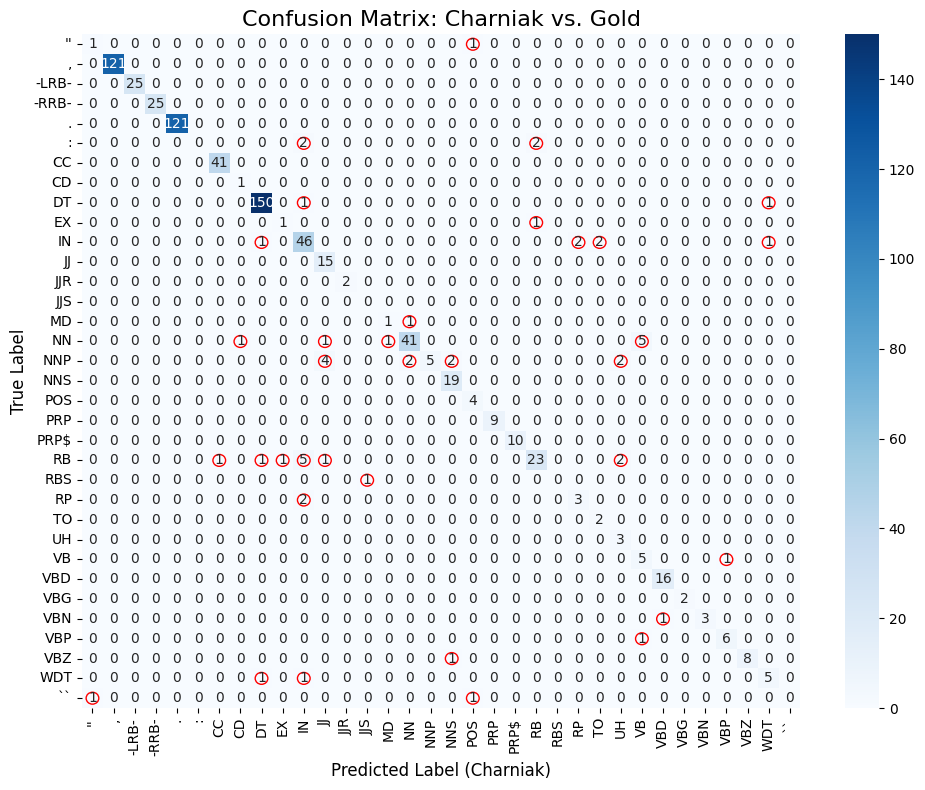

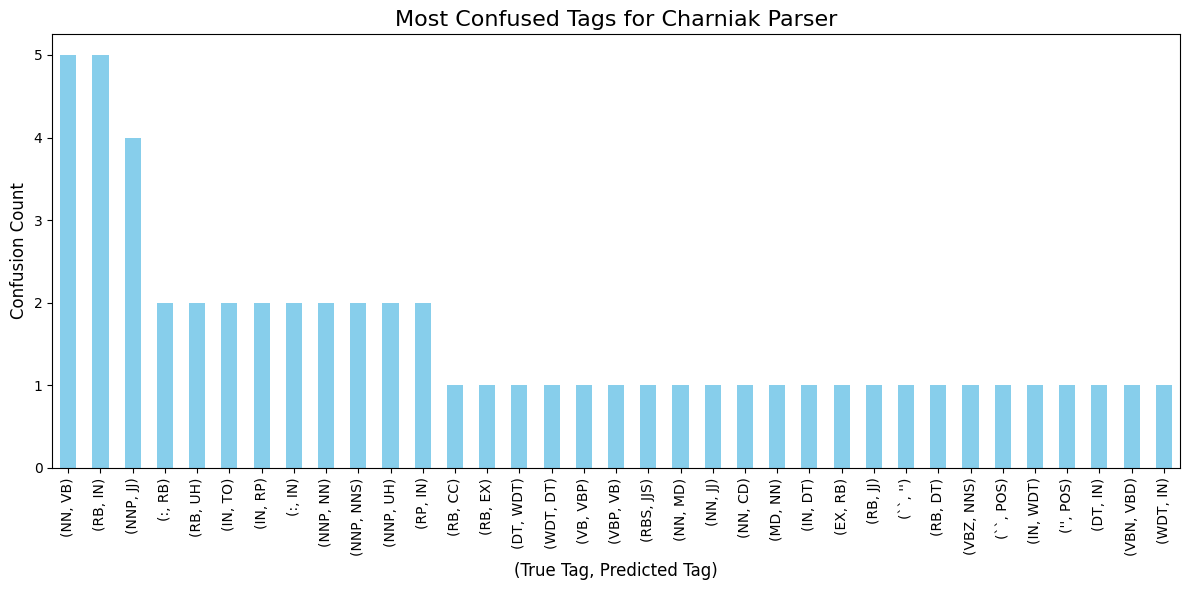

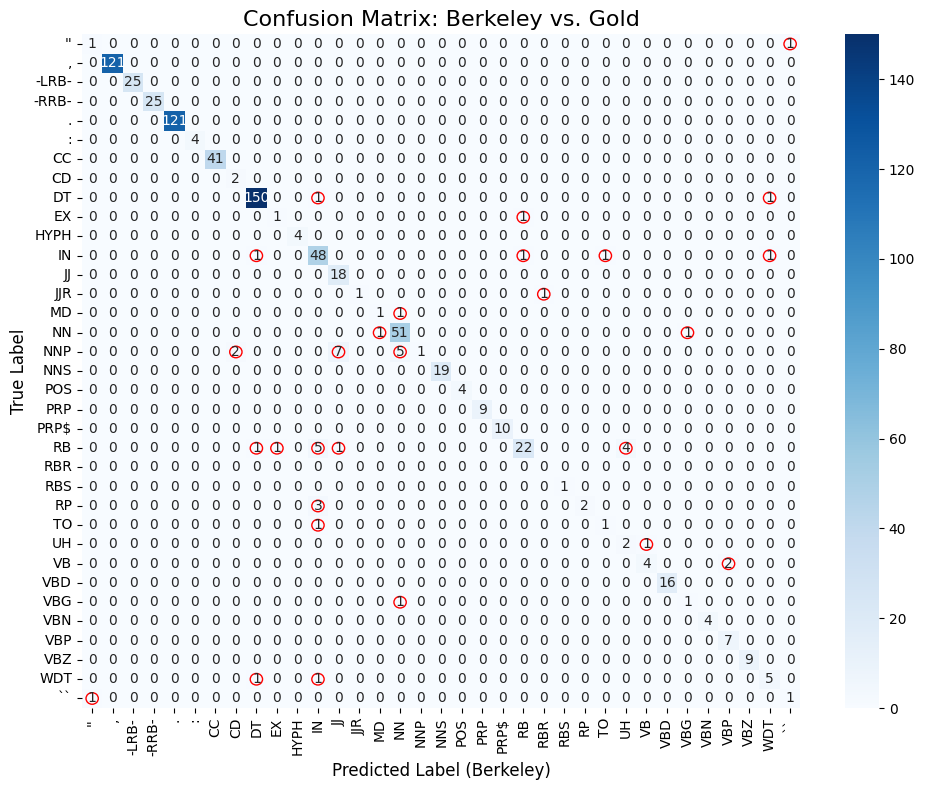

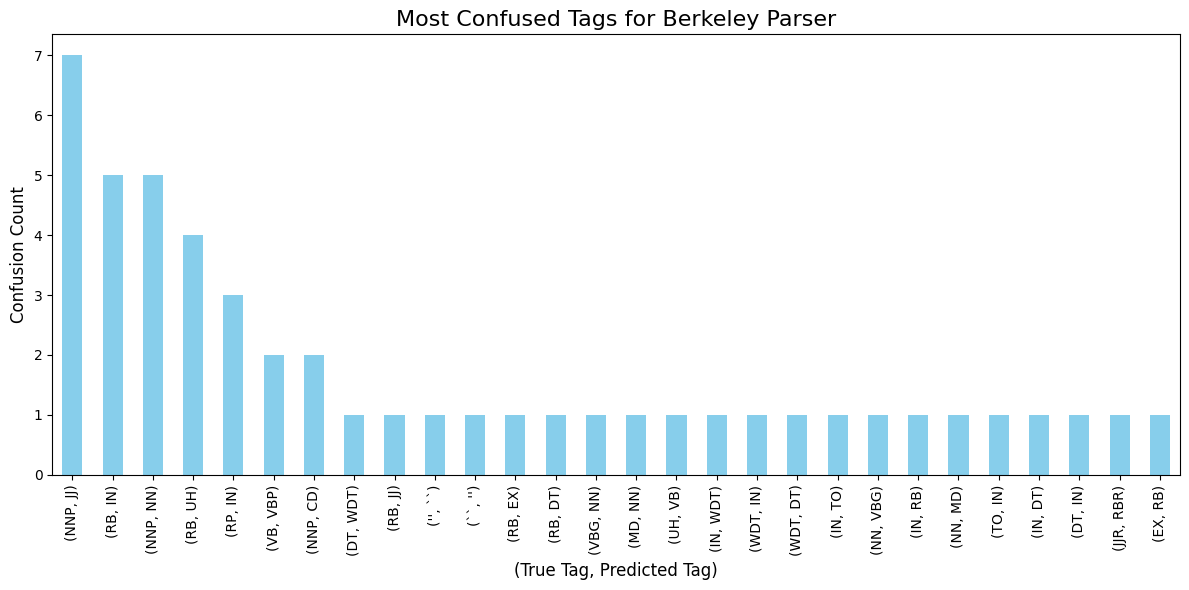

In [15]:
import pandas as pd
import numpy as np
from nltk import Tree
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Define a function to extract word-tag pairs from tree strings
def extract_word_tags(tree_str_list):
    word_tags = []
    for tree_str in tree_str_list:
        tree = Tree.fromstring(tree_str)
        word_tags.extend(tree.pos())
    return word_tags

# Define a function to plot the confusion counts for non-diagonal elements
def plot_confusion_counts(cm_df, parser_name):
    # Flatten the confusion matrix, filter out diagonal elements and sort by count
    confusion_counts = cm_df.mask(np.eye(len(cm_df), dtype=bool)).stack().sort_values(ascending=False)
    confusion_counts = confusion_counts[confusion_counts > 0]  # Keep only non-zero counts

    # Create a bar plot for the confusion counts
    plt.figure(figsize=(12, 6))
    confusion_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Most Confused Tags for {parser_name} Parser', fontsize=16)
    plt.xlabel('(True Tag, Predicted Tag)', fontsize=12)
    plt.ylabel('Confusion Count', fontsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Define a function to create a confusion matrix and plot it
def create_confusion_matrix(df_parser, df_gold, parser_name):
    # Merge the parser and gold DataFrames on the word column
    df_merged = pd.merge(df_parser, df_gold, on='Word', how='inner')
    
    # Get the list of all unique tags from both the parser and gold standard
    all_tags = sorted(set(df_merged[f'{parser_name}_Tag']).union(df_merged['Gold_Tag']))
    
    # Calculate the confusion matrix with all tags as labels
    cm = confusion_matrix(df_merged['Gold_Tag'], df_merged[f'{parser_name}_Tag'], labels=all_tags)
    
    # Convert the confusion matrix into a DataFrame
    cm_df = pd.DataFrame(cm, index=all_tags, columns=all_tags)
    
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    heatmap = sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=ax)

    # Remove ticks
    # ax.set_xticks([])
    # ax.set_yticks([])

    # Loop through the data to highlight non-zero off-diagonal values
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > 0 and i != j:  # Check for non-zero off-diagonal
                # Add a red circle to highlight errors
                circle = Circle((j+0.5, i+0.5), 0.3, color='red', fill=False)
                ax.add_patch(circle)

    # Improve the aesthetics for scientific presentation
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel(f'Predicted Label ({parser_name})', fontsize=12)
    ax.set_title(f'Confusion Matrix: {parser_name} vs. Gold', fontsize=16)

    # Adjust layout for better fit and display the plot
    plt.tight_layout()
    plt.show()

    # Call the plot_confusion_counts function to plot the confusion counts
    plot_confusion_counts(cm_df, parser_name)

    return cm_df
    

# Extract word-tag pairs for Charniak and Berkeley parsers and the gold standard
charniak_word_tags = extract_word_tags(adjusted_charniak_trees)
berkeley_word_tags = extract_word_tags(berkeley_trees)
gold_word_tags = extract_word_tags(adjusted_gold_trees)

print(gold_word_tags)

# Assuming the word_tags lists are already populated
charniak_total_tokens = len(charniak_word_tags)
berkeley_total_tokens = len(berkeley_word_tags)
gold_total_tokens = len(gold_word_tags)

# Print out the total number of tokens for each parser
print(f"Total number of tokens in Charniak parser output: {charniak_total_tokens}")
print(f"Total number of tokens in Berkeley parser output: {berkeley_total_tokens}")
print(f"Total number of tokens in the Gold Standard: {gold_total_tokens}")


# Create DataFrames for Charniak and Berkeley parsers
df_charniak = pd.DataFrame(charniak_word_tags, columns=['Word', 'Charniak_Tag'])
df_berkeley = pd.DataFrame(berkeley_word_tags, columns=['Word', 'Berkeley_Tag'])
df_gold = pd.DataFrame(gold_word_tags, columns=['Word', 'Gold_Tag'])

# Create and plot confusion matrices for Charniak and Berkeley parsers
cm_charniak = create_confusion_matrix(df_charniak, df_gold, 'Charniak')
cm_berkeley = create_confusion_matrix(df_berkeley, df_gold, 'Berkeley')

### Better Output for Latex Document

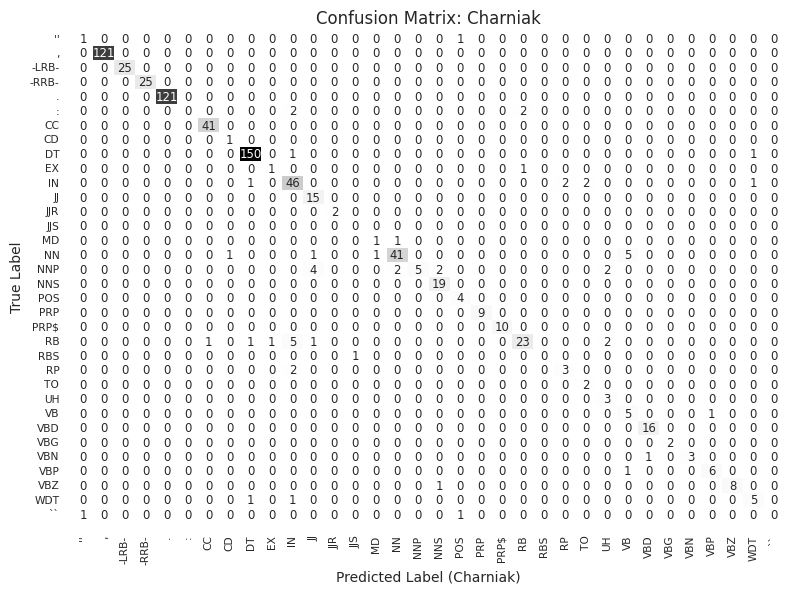

  level_0 level_1    0
0      NN      VB  5.0
1      RB      IN  5.0
2     NNP      JJ  4.0
3       :      RB  2.0
4      RB      UH  2.0


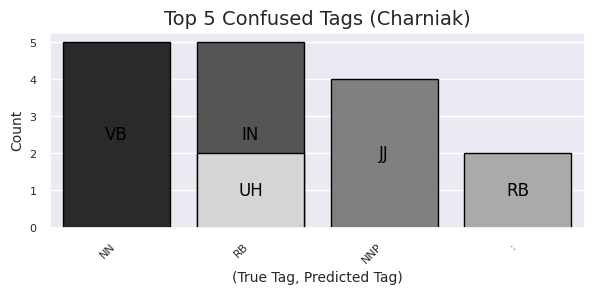

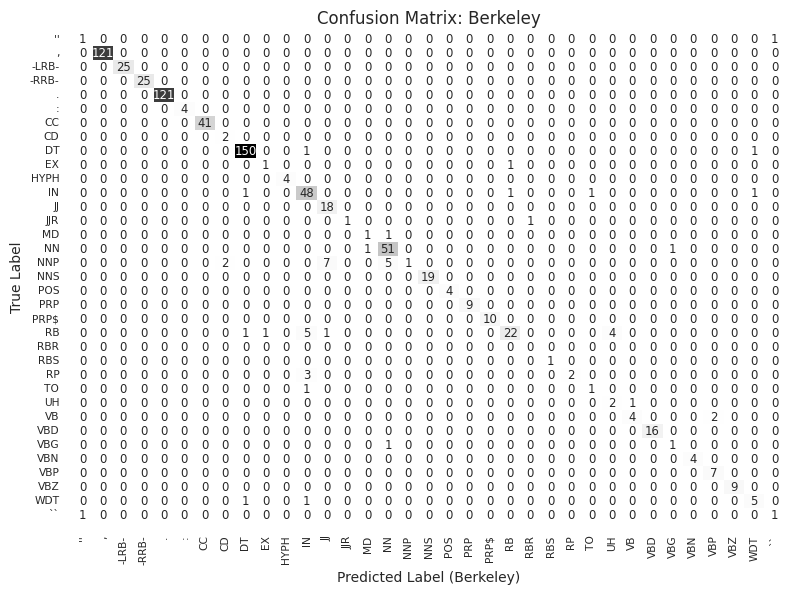

  level_0 level_1    0
0     NNP      JJ  7.0
1      RB      IN  5.0
2     NNP      NN  5.0
3      RB      UH  4.0
4      RP      IN  3.0


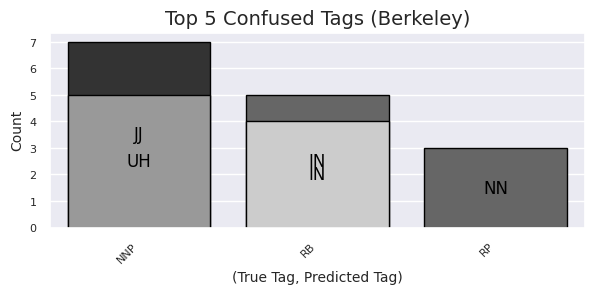

In [56]:
import pandas as pd
import numpy as np
from nltk import Tree
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure that 'Times New Roman' is available and set it as the default font
from matplotlib.font_manager import findfont, FontProperties
try:
    findfont('Times New Roman')
except Exception:
    plt.rcParams['font.family'] = 'serif'
else:
    plt.rcParams['font.family'] = 'Times New Roman'

# Define a function to extract word-tag pairs from tree strings
def extract_word_tags(tree_str_list):
    word_tags = []
    for tree_str in tree_str_list:
        tree = Tree.fromstring(tree_str)
        word_tags.extend(tree.pos())
    return word_tags

# Define a function to plot the confusion counts for non-diagonal elements
def plot_confusion_counts(cm_df, parser_name):
    confusion_counts = cm_df.mask(np.eye(len(cm_df), dtype=bool)).stack().sort_values(ascending=False)
    confusion_counts = confusion_counts[confusion_counts > 0]  # Keep only non-zero counts
    top_confusions = confusion_counts.head(5).reset_index()  # Keep only top five confusions and reset index

    print(top_confusions)

    # Create a bar plot for the top five confusion counts
    plt.figure(figsize=(6, 3))
    barplot = sns.barplot(x='level_0', y=0, hue='level_1', data=top_confusions, palette='gray', edgecolor="black", dodge=False)

    # Remove the legend
    barplot.legend_.remove()

    # Add text annotations in the middle of the bars
    for p, label in zip(barplot.patches, top_confusions['level_1']):
        height = p.get_height()
        # Check if height is not zero (which can happen if the bar is too small)
        if height > 0:
            barplot.annotate(label, 
                            (p.get_x() + p.get_width() / 2., height/2), 
                            ha='center', va='center', 
                            fontsize=12, color='black', 
                            xytext=(0, 0), 
                            textcoords='offset points')
        else:
            # If the bar is too small for the label, place it above the bar
            barplot.annotate(label, 
                            (p.get_x() + p.get_width() / 2., 0.1), 
                            ha='center', va='bottom', 
                            fontsize=9, color='black', 
                            xytext=(0, 0), 
                            textcoords='offset points')

    plt.title(f'Top 5 Confused Tags ({parser_name})', fontsize=14)
    plt.xlabel('(True Tag, Predicted Tag)', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()


# Define a function to create a confusion matrix and plot it
def create_confusion_matrix(df_parser, df_gold, parser_name):
    # Merge the parser and gold DataFrames on the word column
    df_merged = pd.merge(df_parser, df_gold, on='Word', how='inner')
    
    # Get the list of all unique tags from both the parser and gold standard
    all_tags = sorted(set(df_merged[f'{parser_name}_Tag']).union(df_merged['Gold_Tag']))
    
    # Calculate the confusion matrix with all tags as labels
    cm = confusion_matrix(df_merged['Gold_Tag'], df_merged[f'{parser_name}_Tag'], labels=all_tags)
    
    # Convert the confusion matrix into a DataFrame
    cm_df = pd.DataFrame(cm, index=all_tags, columns=all_tags)
    
    # Plot the confusion matrix in a more compact and scientific format
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=0.7)
    heatmap = sns.heatmap(cm_df, annot=True, fmt='d', cmap='Greys', cbar=False)
    heatmap.set_ylabel('True Label', fontsize=10)
    heatmap.set_xlabel(f'Predicted Label ({parser_name})', fontsize=10)
    heatmap.set_title(f'Confusion Matrix: {parser_name}', fontsize=12)

    # Adjust layout for better fit and display the plot
    plt.tight_layout()
    plt.show()

    # Call the plot_confusion_counts function to plot the confusion counts
    plot_confusion_counts(cm_df, parser_name)

    return cm_df

# Assuming the word_tags lists are already populated
# (Your existing code for populating word-tag pairs goes here)

# Create DataFrames for Charniak and Berkeley parsers
df_charniak = pd.DataFrame(charniak_word_tags, columns=['Word', 'Charniak_Tag'])
df_berkeley = pd.DataFrame(berkeley_word_tags, columns=['Word', 'Berkeley_Tag'])
df_gold = pd.DataFrame(gold_word_tags, columns=['Word', 'Gold_Tag'])

# Create and plot confusion matrices for Charniak and Berkeley parsers
cm_charniak = create_confusion_matrix(df_charniak, df_gold, 'Charniak')
cm_berkeley = create_confusion_matrix(df_berkeley, df_gold, 'Berkeley')


# Analysis of duplicates

In [17]:
from collections import Counter

# Provided list of tuples
word_tag_pairs = [('my', 'PRP$'), ('aunt', 'NN'), ("'s", 'POS'), ('can', 'NN'), ('opener', 'NN'), ('can', 'MD'), ('open', 'VB'), ('a', 'DT'), ('drum', 'NN'), ('.', '.'), ('the', 'DT'), ('old', 'JJ'), ('car', 'NN'), ('broke', 'VBD'), ('down', 'RP'), ('in', 'IN'), ('the', 'DT'), ('car', 'NN'), ('park', 'NN'), ('.', '.'), ('at', 'RB'), ('least', 'RBS'), ('two', 'CD'), ('men', 'NNS'), ('broke', 'VBD'), ('in', 'RP'), ('and', 'CC'), ('stole', 'VBD'), ('my', 'PRP$'), ('tv', 'NN'), ('.', '.'), ('kim', 'NNP'), ('and', 'CC'), ('sandy', 'NNP'), ('both', 'RB'), ('broke', 'VBD'), ('up', 'RP'), ('with', 'IN'), ('their', 'PRP$'), ('partners', 'NNS'), ('.', '.'), ('the', 'DT'), ('horse', 'NN'), ('as', 'RB'), ('well', 'RB'), ('as', 'RB'), ('the', 'DT'), ('rabbits', 'NNS'), ('which', 'WDT'), ('we', 'PRP'), ('wanted', 'VBD'), ('to', 'TO'), ('eat', 'VB'), ('has', 'VBZ'), ('escaped', 'VBN'), ('.', '.'), ('it', 'PRP'), ('was', 'VBD'), ('my', 'PRP$'), ('aunt', 'NN'), ("'s", 'POS'), ('car', 'NN'), ('which', 'WDT'), ('we', 'PRP'), ('sold', 'VBD'), ('at', 'IN'), ('auction', 'NN'), ('last', 'RB'), ('year', 'NN'), ('in', 'IN'), ('february', 'NNP'), ('.', '.'), ('natural', 'JJ'), ('disasters', 'NNS'), ('–', ':'), ('storms', 'NNS'), (',', ','), ('flooding', 'NN'), (',', ','), ('hurricanes', 'NNS'), ('–', ':'), ('occur', 'VBP'), ('infrequently', 'RB'), ('but', 'CC'), ('cause', 'VBP'), ('devastation', 'NN'), ('that', 'WDT'), ('strains', 'VBZ'), ('resources', 'NNS'), ('to', 'IN'), ('breaking', 'NN'), ('point', 'NN'), ('.', '.'), ('letters', 'NNS'), ('delivered', 'VBN'), ('on', 'IN'), ('time', 'NN'), ('by', 'IN'), ('old', 'JJ'), ('-', 'HYPH'), ('fashioned', 'JJ'), ('means', 'NNS'), ('are', 'VBP'), ('increasingly', 'RB'), ('rare', 'JJ'), (',', ','), ('so', 'RB'), ('it', 'PRP'), ('is', 'VBZ'), ('as', 'RB'), ('well', 'RB'), ('that', 'IN'), ('that', 'DT'), ('is', 'VBZ'), ('not', 'RB'), ('the', 'DT'), ('only', 'JJ'), ('option', 'NN'), ('available', 'JJ'), ('.', '.'), ('english', 'NNP'), ('also', 'RB'), ('has', 'VBZ'), ('many', 'JJ'), ('words', 'NNS'), ('of', 'IN'), ('more', 'JJR'), ('or', 'CC'), ('less', 'JJR'), ('unique', 'JJ'), ('function', 'NN'), (',', ','), ('including', 'VBG'), ('interjections', 'NNS'), ('-LRB-', '-LRB-'), ('oh', 'UH'), (',', ','), ('ah', 'UH'), ('-RRB-', '-RRB-'), (',', ','), ('negatives', 'NNS'), ('-LRB-', '-LRB-'), ('no', 'RB'), (',', ','), ('not', 'RB'), ('-RRB-', '-RRB-'), (',', ','), ('politeness', 'NN'), ('markers', 'NNS'), ('-LRB-', '-LRB-'), ('please', 'UH'), (',', ','), ('thank', 'VB'), ('you', 'PRP'), ('-RRB-', '-RRB-'), (',', ','), ('and', 'CC'), ('the', 'DT'), ('existential', 'JJ'), ("'", '``'), ('there', 'RB'), ("'", "''"), ('-LRB-', '-LRB-'), ('there', 'EX'), ('are', 'VBP'), ('horses', 'NNS'), ('but', 'CC'), ('not', 'RB'), ('unicorns', 'NNS'), ('-RRB-', '-RRB-'), ('among', 'IN'), ('others', 'NNS'), ('.', '.'), ('the', 'DT'), ('penn', 'NNP'), ('treebank', 'NNP'), ('tagset', 'NN'), ('was', 'VBD'), ('culled', 'VBN'), ('from', 'IN'), ('the', 'DT'), ('original', 'JJ'), ('87', 'CD'), ('-', 'HYPH'), ('tag', 'NN'), ('tagset', 'NN'), ('for', 'IN'), ('the', 'DT'), ('brown', 'NNP'), ('corpus', 'NNP'), ('.', '.'), ('for', 'IN'), ('example', 'NN'), ('the', 'DT'), ('original', 'JJ'), ('brown', 'NNP'), ('and', 'CC'), ('c5', 'NNP'), ('tagsets', 'NNS'), ('include', 'VBP'), ('a', 'DT'), ('separate', 'JJ'), ('tag', 'NN'), ('for', 'IN'), ('each', 'DT'), ('of', 'IN'), ('the', 'DT'), ('different', 'JJ'), ('forms', 'NNS'), ('of', 'IN'), ('the', 'DT'), ('verbs', 'NNS'), ('do', 'VB'), ('-LRB-', '-LRB-'), ('e.g.', 'RB'), ('c5', 'NNP'), ('tag', 'NN'), ('vdd', 'NN'), ('for', 'IN'), ('did', 'VBN'), ('and', 'CC'), ('vdg', 'NN'), ('tag', 'NN'), ('for', 'IN'), ('doing', 'VBG'), ('-RRB-', '-RRB-'), (',', ','), ('be', 'VB'), ('and', 'CC'), ('have', 'VB'), ('.', '.')]  # replace with the actual list

# Count the occurrences of each word-tag pair
word_tag_counter = Counter(word_tag_pairs)

# Identify duplicates (word-tag pairs with count > 1)
duplicates = {item: count for item, count in word_tag_counter.items() if count > 1}

# Count the number of duplicates and the number of unique elements
num_duplicates = sum(count-1 for count in duplicates.values())  # Subtract 1 to not count the original
num_unique_elements = len(word_tag_counter)

print(f"Number of duplicates: {num_duplicates}")
print(f"Number of unique elements: {num_unique_elements}")
print(duplicates)


Number of duplicates: 83
Number of unique elements: 148
{('my', 'PRP$'): 3, ('aunt', 'NN'): 2, ("'s", 'POS'): 2, ('a', 'DT'): 2, ('.', '.'): 11, ('the', 'DT'): 12, ('old', 'JJ'): 2, ('car', 'NN'): 3, ('broke', 'VBD'): 3, ('in', 'IN'): 2, ('and', 'CC'): 6, ('as', 'RB'): 3, ('well', 'RB'): 2, ('which', 'WDT'): 2, ('we', 'PRP'): 2, ('has', 'VBZ'): 2, ('it', 'PRP'): 2, ('was', 'VBD'): 2, ('–', ':'): 2, (',', ','): 11, ('but', 'CC'): 2, ('-', 'HYPH'): 2, ('are', 'VBP'): 2, ('is', 'VBZ'): 2, ('not', 'RB'): 3, ('of', 'IN'): 3, ('-LRB-', '-LRB-'): 5, ('-RRB-', '-RRB-'): 5, ('tagset', 'NN'): 2, ('original', 'JJ'): 2, ('tag', 'NN'): 4, ('for', 'IN'): 5, ('brown', 'NNP'): 2, ('c5', 'NNP'): 2}


# Attachment errors

# Other

In [10]:
print(charniak_trees[0])
print(berkeley_trees[0])
print(gold_trees[0])

(S1 (S (NP (NP (PRP$ my) (NN aunt) (POS 's)) (NN can) (NN opener)) (VP (MD can) (VP (VB open) (NP (DT a) (VB drum)))) (. .)))
(S (NP (NP (PRP$ my) (NN aunt) (POS 's)) (NN can) (NN opener)) (VP (MD can) (VP (VB open) (NP (DT a) (NN drum)))) (. .))
(TOP  (S   (NP (PRP$ my:0) (NP (NN aunt:1) (NP (POS 's+:2) (NP (NN can:3) (NN opener:4)))))   (VP (MD can:5) (VP (VB open:6) (NP (DT a:7) (NN drum:8)))))  (. .:9))


In [11]:
print("Charniak:", adjusted_charniak_trees[8])
# print(berkeley_trees[6])
print("Gold:", adjusted_gold_trees[8])

Charniak: (S (NP (NNP english)) (ADVP (RB also)) (VP (VBZ has) (NP (NP (JJ many) (NNS words)) (PP (IN of) (NP (JJR more) (CC or) (JJR less) (JJ unique) (NN function)))) (PRN (, ,) (VP (VP (VBG including) (NP (NP (NP (NNS interjections)) (PRN (-LRB- -LRB-) (INTJ (UH oh) (, ,) (UH ah)) (-RRB- -RRB-)) (, ,) (NP (NNS negatives)) (PRN (-LRB- -LRB-) (INTJ (UH no)) (, ,) (ADVP (RB not)) (-RRB- -RRB-)) (, ,) (NP (NN politeness) (NNS markers)) (PRN (-LRB- -LRB-) (S (INTJ (UH please)) (, ,) (VP (VB thank) (NP (PRP you)))) (-RRB- -RRB-))) (, ,) (CC and) (NP (DT the) (JJ existential) (POS '))) (ADVP (RB there)) ('' ') (-LRB- -LRB-) (S (NP (EX there)) (VP (VBP are) (NP (NNS horses))))) (CC but) (RB not) (NP (NNS unicorns))) (-RRB- -RRB-)) (PP (IN among) (NP (NNS others)))) (. .))
Gold: (TOP (S (NP (NNP english))  (VP (ADVP (RB also))   (VP (VBZ has)    (NP (NP (ADJP (JJ many)) (NP (NNS words) (PP (IN of) (NP (NP (ADJP (ADJP (JJR more))     (CONJP (CC or) (ADJP (JJR less)))) (NP (ADJP (JJ unique)) (

In [12]:
berkeley_trees[6]

'(S (NP (NP (JJ natural) (NNS disasters)) (: –) (NP (NNS storms) (, ,) (NN flooding) (, ,) (NNS hurricanes)) (: –)) (VP (VP (VBP occur) (ADVP (RB infrequently))) (CC but) (VP (VBP cause) (NP (NP (NN devastation)) (SBAR (WHNP (WDT that)) (S (VP (VBZ strains) (NP (NNS resources)) (PP (IN to) (NP (VBG breaking) (NN point))))))))) (. .))'

In [32]:
for i in range(20):
    for j in range(1, 20):
        if i/j > 0.62 and i/j < 0.63: 
            print(i/j)
            print("i:", i)
            print("j:", j)


0.625
i: 5
j: 8
0.625
i: 10
j: 16
